In [3]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = "E:/IT/Projects/animal_classifier/train/train/"
TEST_DIR = "E:/IT/Projects/animal_classifier/test/test/"
IMG_SIZE= 50
LR = 1e-5

MODEL_NAME = 'dogsvscat-{}-{}'.format(LR,'2conv-basic')

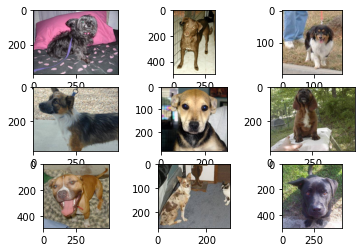

In [4]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = TRAIN_DIR
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

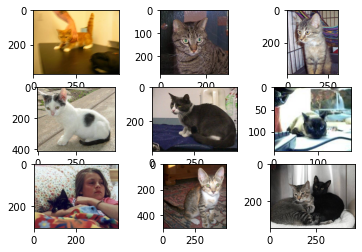

In [5]:
    # plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = TRAIN_DIR
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [6]:
def create_train_data():
    photos, labels = list(), list()
    for img in tqdm(os.listdir(TRAIN_DIR)):
        output = 0.0
        if img.startswith('cat'):
            output = 1.0
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
     
        photos.append(img)
        labels.append(output)
    photos=np.asarray(photos)
    labels=np.asarray(labels)
    print(photos.shape, labels.shape)
    np.save('dogs_vs_cats_photos.npy', photos)
    np.save('dogs_vs_cats_labels.npy', labels)
    return 1
ret = create_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:42<00:00, 582.87it/s]


(25000, 50, 50) (25000,)


In [7]:
from numpy import load
photos = load('dogs_vs_cats_photos.npy')
labels = load('dogs_vs_cats_labels.npy')
print(photos.shape, labels.shape)

(25000, 50, 50) (25000,)


In [10]:
from random import randint
import shutil 
# seed the pseudorandom number generator
from random import seed
from random import random
seed(1)
# seed the pseudorandom number generator
from random import seed
from random import random
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
dataset_home= 'C:/Users/Hirendra/Desktop/dogvscat/dataset_dogs_vs_cats/'
src_directory = TRAIN_DIR
for file in tqdm(os.listdir(src_directory)):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		shutil.copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		shutil.copyfile(src, dst)
        

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:14<00:00, 1771.12it/s]


In [43]:
# define cnn model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dense
from keras.layers import Dense, Dropout, Activation, Flatten

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [44]:
# define model
model = define_model()

In [45]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [46]:
# prepare iterators
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
    class_mode='binary', batch_size=64, target_size=(IMG_SIZE, IMG_SIZE))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
    class_mode='binary', batch_size=64, target_size=(IMG_SIZE, IMG_SIZE))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In [47]:
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)

In [48]:
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

> 75.313


In [49]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot2.png')
    pyplot.close()

In [50]:
summarize_diagnostics(history)